# Projet Marion

### DATA LOADING

Ouvrir les datas, les classés entre trainings, tests, et validation
Regarder pour créer un sous-set de data pour pouvoir run sur notre ordi (voir avec Théo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Device utilisé : cpu
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000 , utilisé : 200
Nombre d'images (val) : 2000 , utilisé : 100
Nombre d'images (test) : 2000 , utilisé : 100


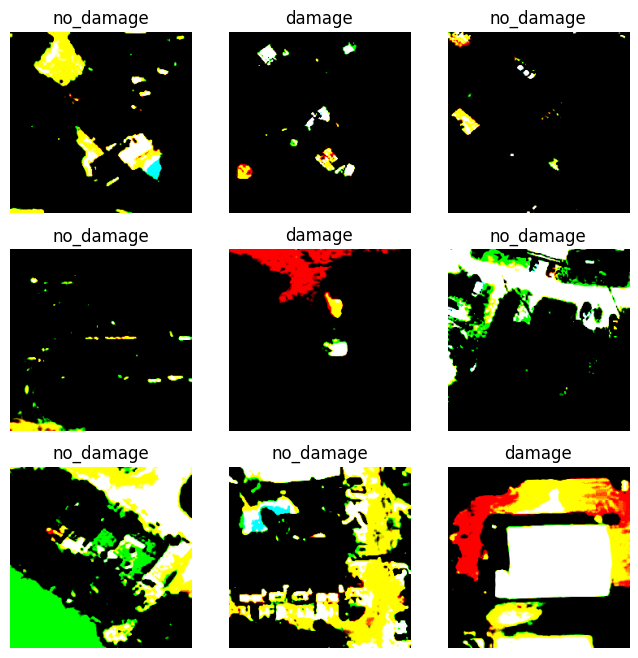

In [29]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

base_dir = "ipeo_hurricane_for_students"

from UCMerced_module import default_transform, unnormalize

# J'utilise default_transform qui vient de la fonction du prof, mais peut-être à modifier

train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# Option pour utiliser un subset stratifié (True) ou l'ensemble complet (False)
use_subset = True  # <- change this ligne pour True/False
samples_per_class = 100  # nombre d'images par classe dans le subset (ajuste selon besoin)
seed = 42


def make_stratified_subset(imagefolder_dataset, samples_per_class=100, seed=42):
    """Retourne un torch.utils.data.Subset stratifié par classe (max samples_per_class par classe)."""
    random.seed(seed)
    class_indices = defaultdict(list)
    # ImageFolder stocke les couples (path, class) dans .samples
    for idx, (path, label) in enumerate(imagefolder_dataset.samples):
        class_indices[label].append(idx)
    selected = []
    for label, indices in class_indices.items():
        k = min(len(indices), samples_per_class)
        if k > 0:
            selected.extend(random.sample(indices, k))
    return Subset(imagefolder_dataset, selected)

# Créer les datasets à utiliser (subset ou full)
if use_subset:
    small_train_ds = make_stratified_subset(train_ds, samples_per_class=samples_per_class, seed=seed)
    small_val_ds = make_stratified_subset(val_ds, samples_per_class=min(50, samples_per_class), seed=seed+1)
    small_test_ds = make_stratified_subset(test_ds, samples_per_class=min(50, samples_per_class), seed=seed+2)
    train_dataset = small_train_ds
    val_dataset = small_val_ds
    test_dataset = small_test_ds
else:
    train_dataset = train_ds
    val_dataset = val_ds
    test_dataset = test_ds

# Ajustements DataLoader pour CPU (si pas de GPU) : réduire batch_size si besoin, num_workers=0 sur macOS
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=False)

print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds), ", utilisé :", len(train_dataset))
print("Nombre d'images (val) :", len(val_ds), ", utilisé :", len(val_dataset))
print("Nombre d'images (test) :", len(test_ds), ", utilisé :", len(test_dataset))


def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)


Loading of Computer Vision Model

In [30]:
from torchvision.models import resnet18

# load a resnet18 with 21 classes and move to device
model = resnet18(num_classes=21).to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loss function

In [31]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

## Optimizer

In [32]:
from torch.optim import SGD

learning_rate = 0.01
# TODO instantiate the SGD optimizer
optimizer = SGD(model.parameters(),lr=learning_rate)

## Test training du model resnet

In [33]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Test sans GPU

In [34]:
print("cpu")
idx, batch = next(enumerate(train_loader))
%timeit training_step(batch, model, optimizer, device="cpu")

cpu
646 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
646 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training sur tous les batchs

In [39]:
import numpy as np

def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []

    for batch in train_dl:
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics (loss is a float already)
        losses.append(loss)
        accuracies.append(accuracy)

    # protections si listes vides
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))


In [45]:
num_epochs = 30

stats = []
for epoch in range(num_epochs):
    trainloss, trainaccuracy = train_epoch(train_loader, model, optimizer, device)
    valloss, valaccuracy = validate_epoch(val_loader, model, device)

    print(f"epoch {epoch}; trainloss {trainloss:.4f}, train accuracy {trainaccuracy*100:.2f}% | valloss {valloss:.4f}, val accuracy {valaccuracy*100:.2f}%")

    stats.append({
        "trainloss": float(trainloss),
        "trainaccuracy": float(trainaccuracy),
        "valloss": float(valloss),
        "valaccuracy": float(valaccuracy),
        "epoch": epoch
    })


epoch 0; trainloss 0.0229, train accuracy 99.52% | valloss 0.2015, val accuracy 91.96%
epoch 1; trainloss 0.0234, train accuracy 99.52% | valloss 0.1591, val accuracy 94.64%
epoch 1; trainloss 0.0234, train accuracy 99.52% | valloss 0.1591, val accuracy 94.64%
epoch 2; trainloss 0.0281, train accuracy 99.04% | valloss 0.1501, val accuracy 94.64%
epoch 2; trainloss 0.0281, train accuracy 99.04% | valloss 0.1501, val accuracy 94.64%
epoch 3; trainloss 0.0084, train accuracy 100.00% | valloss 0.1373, val accuracy 94.64%
epoch 3; trainloss 0.0084, train accuracy 100.00% | valloss 0.1373, val accuracy 94.64%
epoch 4; trainloss 0.0413, train accuracy 98.56% | valloss 1.7462, val accuracy 63.39%
epoch 4; trainloss 0.0413, train accuracy 98.56% | valloss 1.7462, val accuracy 63.39%
epoch 5; trainloss 0.1039, train accuracy 95.67% | valloss 6.0141, val accuracy 56.25%
epoch 5; trainloss 0.1039, train accuracy 95.67% | valloss 6.0141, val accuracy 56.25%
epoch 6; trainloss 0.1068, train accuracy

### Visualisation des erreurs

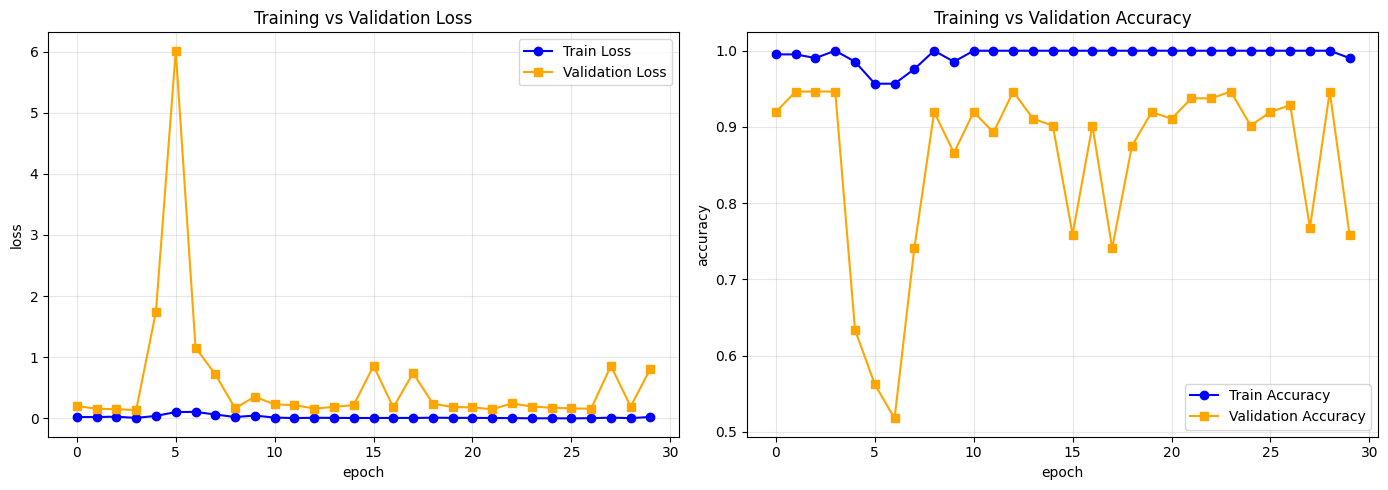

In [46]:
trainlosses = np.array([stat["trainloss"] for stat in stats])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats])
vallosses = np.array([stat["valloss"] for stat in stats])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats])
epochs = np.array([stat["epoch"] for stat in stats])

# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()
